In [1]:
import sys

sys.path.append("ares_transverse_tuning")

In [2]:
import time
from datetime import datetime
from pathlib import Path

import gymnasium as gym
import langchain
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from dotenv import load_dotenv
from gymnasium.wrappers import TimeLimit
from icecream import ic
from langchain.callbacks import FileCallbackHandler, wandb_tracing_enabled
from langchain.chains import LLMChain
from langchain.chat_models import ChatOllama
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from loguru import logger
from openai import RateLimitError
from src.environments.ea import TransverseTuning
from src.eval import Episode
from src.trial import load_trials
from src.wrappers import RecordEpisode, TQDMWrapper

from pacuna import PACuna

In [3]:
load_dotenv()

plt.style.use(["science", "nature", "no-latex"])

langchain.debug = True

In [4]:
# chat_model = ChatOpenAI(model="gpt-3.5-turbo-0125")
# chat_model = ChatOpenAI(model="gpt-4")
# chat_model = ChatOpenAI(model="gpt-4-32k")
# chat_model = ChatOpenAI(model="gpt-4-0125-preview")
# chat_model = ChatOllama(model="mistral:v0.2", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="zephyr", base_url="http://max-wng052:11434")
# chat_model = ChatOllama(model="mixtral:8x7b", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="gemma:2b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="gemma:7b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(
#     model="starling-lm:7b-beta", base_url="http://max-cssbg012:11434"
# )
chat_model = ChatOllama(model="vicuna:7b-16k", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="vicuna:33b", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="llava:34b", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="orca2:7b", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="orca2:13b", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="llama2:7b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="llama2:13b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="llama2:70b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="falcon:180b-chat", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="neural-chat:7b")
# chat_model = ChatOllama(model="mistral-openorca:7b", base_url="http://max-wng052:11434")
# chat_model = ChatOllama(model="phi:chat")
# chat_model = ChatOllama(model="megadolphin:120b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="yi:34b-chat", base_url="http://max-wng054:11434") x
# chat_model = PACuna()

In [5]:
# chat_model.invoke("Hello")

In [6]:
TRIAL_INDEX = 38
trials = load_trials(Path("ares_transverse_tuning/data/trials.yaml"))
trial = trials[TRIAL_INDEX]
trial

Trial(target_beam=array([-0.00061349,  0.00026242,  0.00102625,  0.0003465 ]), incoming_beam=array([ 1.31279831e+08, -7.41156109e-04, -5.82922221e-05,  1.30710745e-04,
       -7.66231824e-06,  3.57008132e-04,  4.35580478e-05,  2.26216856e-04,
        1.96636520e-05,  1.79446160e-05,  2.96076818e-04]), misalignments=array([ 8.31616237e-05,  1.81952708e-04, -3.13049472e-04,  2.17823154e-04,
       -8.04967923e-05,  2.33286971e-04,  1.15469446e-04, -1.41215460e-04]), initial_magnets=array([ 1.06084118e+01, -1.92286568e+01,  2.02686829e-03,  8.72032261e+00,
       -5.51228318e-03]))

In [7]:
model_name = (
    chat_model.model_name if hasattr(chat_model, "model_name") else chat_model.model
).replace(":", "-")
now = datetime.now()

log_dir = (
    Path("data")
    / "paper"
    / "explained"
    / model_name
    / f"trial-{TRIAL_INDEX}_{now.strftime('%Y-%m-%d_%H-%M-%S')}"
)
langchain_log_file = log_dir / "langchain.log"
logger.add(langchain_log_file, colorize=True, enqueue=True)
handler = FileCallbackHandler(langchain_log_file)

In [8]:
log_dir

PosixPath('data/paper/explained/vicuna-7b-16k/trial-38_2024-04-05_15-49-23')

In [9]:
env = TransverseTuning(
    action_mode="direct",
    magnet_init_mode=trial.initial_magnets,
    target_beam_mode=trial.target_beam,
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": False,
    },
)
# env = TimeLimit(env, max_episode_steps=18)
# env = RecordEpisode(env, Path("data/recorded_episodes"))
# env = TQDMWrapper(env)
env

In [10]:
# sample_template = """Magnet settings:
# ```json
# {{
# 	"Q1": {q1:.2f},  // m^-2
# 	"Q2": {q2:.2f},  // m^-2
# 	"CV": {cv:.2f},  // mrad
# 	"Q3": {q3:.2f},  // m^-2
# 	"CH": {ch:.2f}  // mrad
# }}
# ```
# Beam parameters:
# ```json
# {{
# 	"horizontal position": {mu_x:.2f},  // mm
# 	"horizontal size": {sigma_x:.2f},  // mm
# 	"vertical position": {mu_y:.2f},  // mm
# 	"vertical size": {sigma_y:.2f}  // mm
# }}
# ```
# """

In [11]:
sample_template = """Magnet settings:
```json
{{
	"Q1": {q1:.2f},
	"Q2": {q2:.2f},
	"CV": {cv:.2f},
	"Q3": {q3:.2f},
	"CH": {ch:.2f}
}}
```
Beam parameters:
```json
{{
	"mu_x": {mu_x:.2f},
	"sigma_x": {sigma_x:.2f},
	"mu_y": {mu_y:.2f},
	"sigma_y": {sigma_y:.2f}
}}
```
"""
target_template = """Target beam parameters:
```json
{{
	"mu_x": {mu_x:.2f},
	"sigma_x": {sigma_x:.2f},
	"mu_y": {mu_y:.2f},
	"sigma_y": {sigma_y:.2f}
}}
```
"""

In [12]:
message_template = """Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.

You are able to control five magnets in the beam line. The magnets are called Q1, Q2, CV, Q3 and CH.

Q1, Q2 and Q3 are quadrupole magnets. When their k1 strength is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.

CV is vertical steering magnet. When its deflection angle is increased, the beam is steered upwards. When its deflection angle is decreased, the beam is steered downwards. The range of the deflection angle is -6.0 to 6.0 mrad.

CH is horizontal steering magnet. When its deflection angle is increased, the beam is steered to the right. When its deflection angle is decreased, the beam is steered to the left. The range of the deflection angle is -6.0 to 6.0 mrad.

You are optimising four beam parameters: mu_x, sigma_x, mu_y, sigma_y. The beam parameters are measured in millimetres (mm). The target beam parameters are:

{target_beam_parameters}

Below are previously measured pairs of magnet settings and the corresponding observed beam parameters.

{prior_samples}

Give me new magnet settings that are different from all pairs above. The magnet settings you should propose should lead to beam parameters closer the target or, if you do not have enough information yet, maximise information gain for finding new beam parameters. Do not set any magnet setting to zero. Smooth changes relative to the last magnet settings are preferred.

{format_instructions}

Do not add comments to the output JSON.
"""

In [13]:
response_q1 = ResponseSchema(
    name="Q1",
    type="float",
    description="k1 strength of the first quadrupole magnet",
)
response_q2 = ResponseSchema(
    name="Q2",
    type="float",
    description="k1 strength of the second quadrupole magnet",
)
response_cv = ResponseSchema(
    name="CV",
    type="float",
    description="Deflection angle of the vertical steering magnet",
)
response_q3 = ResponseSchema(
    name="Q3",
    type="float",
    description="k1 strength of the third quadrupole magnet",
)
response_ch = ResponseSchema(
    name="CH",
    type="float",
    description="Deflection angle of the horizontal steering magnet",
)

output_parser = StructuredOutputParser.from_response_schemas(
    [response_q1, response_q2, response_cv, response_q3, response_ch]
)

print(output_parser.get_format_instructions())

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Q1": float  // k1 strength of the first quadrupole magnet
	"Q2": float  // k1 strength of the second quadrupole magnet
	"CV": float  // Deflection angle of the vertical steering magnet
	"Q3": float  // k1 strength of the third quadrupole magnet
	"CH": float  // Deflection angle of the horizontal steering magnet
}
```


In [14]:
prompt = PromptTemplate.from_template(message_template)
prompt

PromptTemplate(input_variables=['format_instructions', 'prior_samples', 'target_beam_parameters'], template='Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.\n\nYou are able to control five magnets in the beam line. The magnets are called Q1, Q2, CV, Q3 and CH.\n\nQ1, Q2 and Q3 are quadrupole magnets. When their k1 strength is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.\n\nCV is vertical steering magne

In [15]:
chain = LLMChain(
    prompt=prompt, llm=chat_model, output_parser=output_parser, callbacks=[handler]
)
decapitated_chain = LLMChain(prompt=prompt, llm=chat_model)
chain

LLMChain(callbacks=[<langchain.callbacks.file.FileCallbackHandler object at 0x32ffb76d0>], prompt=PromptTemplate(input_variables=['format_instructions', 'prior_samples', 'target_beam_parameters'], template='Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.\n\nYou are able to control five magnets in the beam line. The magnets are called Q1, Q2, CV, Q3 and CH.\n\nQ1, Q2 and Q3 are quadrupole magnets. When their k1 strength is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre o

In [16]:
# # with wandb_tracing_enabled():
# response = decapitated_chain.invoke(
#     {
#         "prior_samples": samples_str,
#         "format_instructions": output_parser.get_format_instructions(),
#     }
# )
# print(response["text"])

In [17]:
# with wandb_tracing_enabled():
#     response = chain.invoke(
#         {
#             "prior_samples": samples_str,
#             "format_instructions": output_parser.get_format_instructions(),
#         }
#     )
# print(response["text"])

In [18]:
class LLMTransverseTuningAgent:
    """
    An agent for doing transverse beam parameter tuning in the ARES experimental
    area using an LLM via LangChain.
    """

    #     message_template = """Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.
    #
    # The target beam parameters I want you to find are:
    #  - horizontal position: 0.0 μm
    #  - horizontal size: 0.0 μm
    #  - vertical position: 0.0 μm
    #  - vertical size: 0.0 μm
    #
    # You are able to control five magnets in the beam line. The magnets are called:
    #  - Q1
    #  - Q2
    #  - CV
    #  - Q3
    #  - CH
    #
    # Q1, Q2, Q3 are quadrupole magnets. When their k1 strenth is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.
    #
    # CV is vertical steering magnet. When its deflection angle is increased, the beam is steered upwards. When its deflection angle is decreased, the beam is steered downwards. The range of the deflection angle is -6.0 to 6.0 mrad.
    #
    # CH is horizontal steering magnet. When its deflection angle is increased, the beam is steered to the right. When its deflection angle is decreased, the beam is steered to the left. The range of the deflection angle is -6.0 to 6.0 mrad.
    #
    # I have some pairs of magnet settings and the corresponding beam parameters.
    #
    # {prior_samples}
    #
    # Give me new magnet settings that are different from all pairs above, and will result in transnverse beam parameters closer to the target beam parameters than any of the above. Beam parameters less than 40 μm from their target are considered optimal. If you do not know which magnet settings would improve the beam parameters, choose magnet settings that maximise information gain. Smooth changes to the magnet settings are preferred. Do not write code.
    #
    # {format_instructions}
    # """

    #     sample_template = """Magnet settings:
    #  - Q1: {q1} m^-2
    #  - Q2: {q2} m^-2
    #  - CV: {cv} mrad
    #  - Q3: {q3} m^-2
    #  - CH: {ch} mrad
    # Beam parameters:
    #  - horizontal position: {mu_x} μm
    #  - horizontal size: {sigma_x} μm
    #  - vertical position: {mu_y} μm
    #  - vertical size: {sigma_y} μm
    # """

    def __init__(
        self, env: gym.Env, warmup_steps: int = 0, verbose: bool = False
    ) -> None:
        self.env = env
        self.warmup_steps = warmup_steps
        self.verbose = verbose

        global chain
        self._chain = chain

        self._observations = []

    def predict(self, observation: dict) -> np.ndarray:
        """
        Takes an observation from the environment and returns an action.
        """
        self._observations.append(observation)

        # -1 because we already have the first observation from the reset
        if len(self._observations) < self.warmup_steps - 1:
            return self.env.action_space.sample()

        global sample_template
        global target_template
        global output_parser

        samples_str = "\n".join(
            sample_template.format(
                q1=obs["magnets"][0],
                q2=obs["magnets"][1],
                cv=obs["magnets"][2] * 1e3,
                q3=obs["magnets"][3],
                ch=obs["magnets"][4] * 1e3,
                mu_x=obs["beam"][0] * 1e6,
                sigma_x=obs["beam"][1] * 1e6,
                mu_y=obs["beam"][2] * 1e6,
                sigma_y=obs["beam"][3] * 1e6,
            )
            for obs in self._observations
        )
        target_str = target_template.format(
            mu_x=observation["target"][0] * 1e3,
            sigma_x=observation["target"][1] * 1e3,
            mu_y=observation["target"][2] * 1e3,
            sigma_y=observation["target"][3] * 1e3,
        )

        try:
            response = self._chain.invoke(
                {
                    "target_beam_parameters": target_str,
                    "prior_samples": samples_str,
                    "format_instructions": output_parser.get_format_instructions(),
                }
            )
        except Exception as e:
            time.sleep(5.0)
            response = self._chain.invoke(
                {
                    "target_beam_parameters": target_str,
                    "prior_samples": samples_str,
                    "format_instructions": output_parser.get_format_instructions(),
                }
            )

        if self.verbose:
            print(response["explanation"])

        action = np.array(
            [
                response["text"]["Q1"],
                response["text"]["Q2"],
                response["text"]["CV"] / 1e3,
                response["text"]["Q3"],
                response["text"]["CH"] / 1e3,
            ]
        )

        return action

In [19]:
env = TransverseTuning(
    action_mode="direct",
    magnet_init_mode=trial.initial_magnets,
    target_beam_mode=trial.target_beam,
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": False,
    },
)
env = TimeLimit(env, max_episode_steps=50)
env = RecordEpisode(env, log_dir / "recorded_episodes")
env = TQDMWrapper(env)
env

<TQDMWrapper<RecordEpisode<TimeLimit<TransverseTuning instance>>>>

In [20]:
agent = LLMTransverseTuningAgent(env=env, warmup_steps=0, verbose=False)
agent

In [21]:
with wandb_tracing_enabled():
    observation, info = env.reset()
    done = False
    while not done:
        action = agent.predict(observation)
        observation, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Streaming LangChain activity to W&B at https://wandb.ai/msk-ipc/llm-accelerator-tuning/runs/cdugqykg
wandb: `WandbTracer` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `langchain`.
/opt/homebrew/Caskroom/miniforge/base/envs/llm-accelerator-tuning/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.pbar to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.pbar` for environment variables or `env.get_wrapper_attr('pbar')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/50 [00:00<?, ?it/s]

[chain/start] [1:chain:LLMChain] Entering Chain run with input:
{
  "target_beam_parameters": "Target beam parameters:\n```json\n{\n\t\"mu_x\": -0.61,\n\t\"sigma_x\": 0.26,\n\t\"mu_y\": 1.03,\n\t\"sigma_y\": 0.35\n}\n```\n",
  "prior_samples": "Magnet settings:\n```json\n{\n\t\"Q1\": 10.61,\n\t\"Q2\": -19.23,\n\t\"CV\": 2.03,\n\t\"Q3\": 8.72,\n\t\"CH\": -5.51\n}\n```\nBeam parameters:\n```json\n{\n\t\"mu_x\": -1633.87,\n\t\"sigma_x\": 154.10,\n\t\"mu_y\": 2865.50,\n\t\"sigma_y\": 275.46\n}\n```\n",
  "format_instructions": "The output should be a markdown code snippet formatted in the following schema, including the leading and trailing \"```json\" and \"```\":\n\n```json\n{\n\t\"Q1\": float  // k1 strength of the first quadrupole magnet\n\t\"Q2\": float  // k1 strength of the second quadrupole magnet\n\t\"CV\": float  // Deflection angle of the vertical steering magnet\n\t\"Q3\": float  // k1 strength of the third quadrupole magnet\n\t\"CH\": float  // Deflection angle of the horizont

  2%|▏         | 1/50 [00:04<04:03,  4.98s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [4.95s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -15,\n\t\"Q2\": 7,\n\t\"CV\": 3,\n\t\"Q3\": -6,\n\t\"CH\": -8\n}\n```\nExplanation:\n\n* Increasing the k1 strength of Q1 and decreasing that of Q2 focuses the beam in both planes. However, increasing Q2's k1 strength is more effective than increasing Q1's since it has a larger range. Thus, we set Q1 to -15 (halfway between its minimum and maximum values) and Q2 to 7 (slightly below its minimum value).\n* Increasing the deflection angle of CV steers the beam upwards, while decreasing it moves the beam downwards. Since we want to increase mu\\_x, we set CV's deflection angle to 3 (its maximum value).\n* The k1 strength of Q3 should be set to zero since it doesn't affect the horizontal plane and has a range of -30 to 30 m^-2. This leaves only CH's deflection angle to control mu\\_y. Increasing its deflection angle moves the beam to

  4%|▍         | 2/50 [00:06<02:07,  2.66s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.03s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 0,\n\t\"Q2\": 0,\n\t\"CV\": 0,\n\t\"Q3\": 0,\n\t\"CH\": 0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:35.760083198Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 945480978,
          "load_duration": 7084115,
          "prompt_eval_count": 369,
          "prompt_eval_duration": 301439000,
          "eval_count": 51,
          "eval_duration": 633677000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\"Q1\"

  6%|▌         | 3/50 [00:07<01:30,  1.92s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.00s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -8,\n    \"Q2\": -30,\n    \"CV\": 4,\n    \"Q3\": 15,\n    \"CH\": -3\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:36.833912418Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 967565951,
          "load_duration": 6461767,
          "prompt_eval_count": 365,
          "prompt_eval_duration": 296236000,
          "eval_count": 53,
          "eval_duration": 661983000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```js

  8%|▊         | 4/50 [00:08<01:14,  1.62s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.13s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -7.0,\n\t\"Q2\": -21.0,\n\t\"CV\": 1.5,\n\t\"Q3\": 9.0,\n\t\"CH\": -4.0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:37.992871851Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1093150473,
          "load_duration": 6131199,
          "prompt_eval_count": 370,
          "prompt_eval_duration": 306301000,
          "eval_count": 62,
          "eval_duration": 777616000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```js

 10%|█         | 5/50 [00:09<01:05,  1.46s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.17s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 0.0,\n\t\"Q2\": -4.5,\n\t\"CV\": 3.5,\n\t\"Q3\": 8.0,\n\t\"CH\": -6.5\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:39.18762117Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1088245660,
          "load_duration": 6628727,
          "prompt_eval_count": 369,
          "prompt_eval_duration": 301748000,
          "eval_count": 61,
          "eval_duration": 776612000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\

 12%|█▏        | 6/50 [00:10<01:00,  1.39s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.23s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -12.50,\n\t\"Q2\": 4.80,\n\t\"CV\": 1.70,\n\t\"Q3\": 12.50,\n\t\"CH\": 1.90\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:40.423462354Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1198144976,
          "load_duration": 24016266,
          "prompt_eval_count": 367,
          "prompt_eval_duration": 309619000,
          "eval_count": 68,
          "eval_duration": 861207000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "

 14%|█▍        | 7/50 [00:11<00:57,  1.34s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.23s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -7.50,\n\t\"Q2\": -48.00,\n\t\"CV\": 2.00,\n\t\"Q3\": 11.50,\n\t\"CH\": -6.90\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:41.665736057Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1197096611,
          "load_duration": 9938326,
          "prompt_eval_count": 367,
          "prompt_eval_duration": 302369000,
          "eval_count": 68,
          "eval_duration": 881367000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 16%|█▌        | 8/50 [00:13<00:54,  1.29s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.18s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -24.0,\n\t\"Q2\": 17.5,\n\t\"CV\": -3.5,\n\t\"Q3\": -18.0,\n\t\"CH\": -4.9\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:42.846801073Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1144303394,
          "load_duration": 6235788,
          "prompt_eval_count": 371,
          "prompt_eval_duration": 312841000,
          "eval_count": 64,
          "eval_duration": 821692000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "``

 18%|█▊        | 9/50 [00:14<00:49,  1.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.01s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8,\n\t\"Q2\": 5,\n\t\"CV\": 3,\n\t\"Q3\": -4,\n\t\"CH\": -5\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:43.885114617Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 979912009,
          "load_duration": 7394504,
          "prompt_eval_count": 370,
          "prompt_eval_duration": 307664000,
          "eval_count": 51,
          "eval_duration": 661135000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\"Q

 20%|██        | 10/50 [00:15<00:48,  1.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.19s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -5.0,\n\t\"Q2\": 2.5,\n\t\"CV\": 0.5,\n\t\"Q3\": -7.0,\n\t\"CH\": -4.0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:45.108747515Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1155407775,
          "load_duration": 27965442,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 321716000,
          "eval_count": 61,
          "eval_duration": 800998000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```js

 22%|██▏       | 11/50 [00:16<00:47,  1.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.21s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -4.50,\n    \"Q2\": 9.00,\n    \"CV\": 0.50,\n    \"Q3\": -6.00,\n    \"CH\": -5.18\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:46.313000461Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1171183061,
          "load_duration": 6519157,
          "prompt_eval_count": 365,
          "prompt_eval_duration": 313331000,
          "eval_count": 66,
          "eval_duration": 847502000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "co

 24%|██▍       | 12/50 [00:17<00:46,  1.23s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.27s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -20.86,\n    \"Q2\": 5.00,\n    \"CV\": -4.50,\n    \"Q3\": 8.00,\n    \"CH\": -3.50\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:49:47.609560684Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1201594195,
          "load_duration": 8025702,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 307278000,
          "eval_count": 67,
          "eval_duration": 882318000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "c

 26%|██▌       | 13/50 [00:38<04:18,  7.00s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": 0,\n    \"Q2\": -15,\n    \"CV\": 3,\n    \"Q3\": 8,\n    \"CH\": -6\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:07.854622281Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 747565131,
          "load_duration": 9679247,
          "prompt_eval_duration": 19595000,
          "eval_count": 52,
          "eval_duration": 713002000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n    \"Q1\": 0,\n    \"Q2\": -15,\n   

 28%|██▊       | 14/50 [00:39<03:09,  5.26s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.23s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": 2.0,\n    \"Q2\": -10.5,\n    \"CV\": 3.0,\n    \"Q3\": 7.5,\n    \"CH\": -6.5\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:09.112301822Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1199856812,
          "load_duration": 14422289,
          "prompt_eval_count": 368,
          "prompt_eval_duration": 327794000,
          "eval_count": 62,
          "eval_duration": 851939000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "conten

 30%|███       | 15/50 [00:40<02:21,  4.05s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.25s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -30.0,\n\t\"Q2\": 10.0,\n\t\"CV\": 10.0,\n\t\"Q3\": -15.0,\n\t\"CH\": -8.0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:10.367911439Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1213491954,
          "load_duration": 6794756,
          "prompt_eval_count": 367,
          "prompt_eval_duration": 322668000,
          "eval_count": 65,
          "eval_duration": 879764000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "``

 32%|███▏      | 16/50 [00:41<01:48,  3.19s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.17s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 5.0,\n\t\"Q2\": -6.0,\n\t\"CV\": -3.0,\n\t\"Q3\": 8.0,\n\t\"CH\": -4.0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:11.545041841Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1138743156,
          "load_duration": 6886696,
          "prompt_eval_count": 372,
          "prompt_eval_duration": 318521000,
          "eval_count": 61,
          "eval_duration": 808851000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 34%|███▍      | 17/50 [00:42<01:25,  2.59s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.17s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -6.0,\n\t\"Q2\": -8.0,\n\t\"CV\": 3.5,\n\t\"Q3\": 9.5,\n\t\"CH\": -4.5\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:12.740196389Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1149989737,
          "load_duration": 7168085,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 320630000,
          "eval_count": 61,
          "eval_duration": 817881000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 36%|███▌      | 18/50 [00:47<01:39,  3.12s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [4.33s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To find new magnet settings that lead to beam parameters closer to the target, I will use a simple optimization algorithm. My suggestions for the magnet settings are based on smooth changes relative to the last magnet settings.\n\nHere is an example of how you could format the suggested magnet settings in Markdown code snippet format:\n```json\n{\n\t\"Q1\": 3.50,\n\t\"Q2\": -6.87,\n\t\"CV\": 2.10,\n\t\"Q3\": -14.50,\n\t\"CH\": -4.90\n}\n```\nThese settings are chosen to focus the beam in the vertical plane and defocus it in the horizontal plane while keeping the beam centered in the diagnostic screen. The k1 strengths of Q1 and Q2 are increased to improve the focusing in the vertical plane, and the CV magnet's deflection angle is reduced slightly to prevent excessive steering. The CH magnet's deflection angle is kept negative to counteract any unwante

 38%|███▊      | 19/50 [00:48<01:19,  2.57s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.28s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -8.00,\n    \"Q2\": -47.50,\n    \"CV\": 3.50,\n    \"Q3\": -6.00,\n    \"CH\": 1.90\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:18.381084163Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1245446184,
          "load_duration": 7505474,
          "prompt_eval_count": 368,
          "prompt_eval_duration": 329190000,
          "eval_count": 67,
          "eval_duration": 903888000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "c

 40%|████      | 20/50 [00:49<01:05,  2.17s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.25s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -2.50,\n\t\"Q2\": 3.75,\n\t\"CV\": -4.00,\n\t\"Q3\": 9.00,\n\t\"CH\": -4.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:19.640265089Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1225917282,
          "load_duration": 6837466,
          "prompt_eval_count": 370,
          "prompt_eval_duration": 314622000,
          "eval_count": 66,
          "eval_duration": 899722000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "`

 42%|████▏     | 21/50 [00:51<00:55,  1.90s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.26s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -8.50,\n    \"Q2\": 3.50,\n    \"CV\": -6.00,\n    \"Q3\": -4.00,\n    \"CH\": -5.18\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:20.910822315Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1233129347,
          "load_duration": 8309221,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 321850000,
          "eval_count": 66,
          "eval_duration": 898168000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "c

 44%|████▍     | 22/50 [01:05<02:37,  5.63s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -7,\n    \"Q2\": 5,\n    \"CV\": -3,\n    \"Q3\": 6,\n    \"CH\": -2\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:35.226232053Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 762804299,
          "load_duration": 7853783,
          "prompt_eval_duration": 19556000,
          "eval_count": 51,
          "eval_duration": 729123000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n    \"Q1\": -7,\n    \"Q2\": 5,\n    

 46%|████▌     | 23/50 [01:06<01:56,  4.33s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.27s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.5,\n\t\"Q2\": -14.5,\n\t\"CV\": 3.0,\n\t\"Q3\": 7.0,\n\t\"CH\": 1.5\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:36.514197509Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1234696692,
          "load_duration": 6438077,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 335808000,
          "eval_count": 62,
          "eval_duration": 886150000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 48%|████▊     | 24/50 [01:07<01:28,  3.40s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.22s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -5.0,\n\t\"Q2\": -7.5,\n\t\"CV\": 0.5,\n\t\"Q3\": 2.0,\n\t\"CH\": 0.9\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:37.747728605Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1191850971,
          "load_duration": 20832097,
          "prompt_eval_count": 369,
          "prompt_eval_duration": 335542000,
          "eval_count": 61,
          "eval_duration": 830158000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 50%|█████     | 25/50 [01:15<01:53,  4.52s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 0,\n\t\"Q2\": -5,\n\t\"CV\": 0.5,\n\t\"Q3\": 7,\n\t\"CH\": -4\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:44.889560709Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 806702855,
          "load_duration": 8900498,
          "prompt_eval_duration": 20418000,
          "eval_count": 53,
          "eval_duration": 771070000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\"Q1\": 0,\n\t\"Q2\": -5,\n\t\"CV\": 0.5,\n\

 52%|█████▏    | 26/50 [01:16<01:25,  3.55s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.28s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -20.5,\n\t\"Q2\": 7.0,\n\t\"CV\": 3.0,\n\t\"Q3\": -6.0,\n\t\"CH\": -4.0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:50:46.188423868Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1243423302,
          "load_duration": 5815840,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 341437000,
          "eval_count": 62,
          "eval_duration": 890842000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```js

 54%|█████▍    | 27/50 [01:38<03:30,  9.14s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.09s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -30.24,\n\t\"Q2\": -19.86,\n\t\"CV\": 2.50,\n\t\"Q3\": -7.00,\n\t\"CH\": -4.90\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:51:08.359139847Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1046401920,
          "load_duration": 9049578,
          "prompt_eval_duration": 20295000,
          "eval_count": 68,
          "eval_duration": 1009511000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\"Q1\": -30.24,\n\t\

 56%|█████▌    | 28/50 [02:03<05:03, 13.79s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.07s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -6.75,\n    \"Q2\": 4.00,\n    \"CV\": 3.50,\n    \"Q3\": 9.50,\n    \"CH\": -3.50\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:51:32.983174837Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1022617675,
          "load_duration": 8263102,
          "prompt_eval_duration": 20489000,
          "eval_count": 66,
          "eval_duration": 987037000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n    \"Q1\": -6.75

 58%|█████▊    | 29/50 [02:21<05:20, 15.26s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.94s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "I will optimize the beam parameters by adjusting the five magnets in the particle accelerator's beam line. Here are my recommendations for the new magnet settings:\n```json\n{\n\t\"Q1\": 0.5,\n\t\"Q2\": -30,\n\t\"CV\": 2,\n\t\"Q3\": 8,\n\t\"CH\": -4.9\n}\n```\nThese new magnet settings should lead to beam parameters closer to the target values while maintaining a reasonable level of focus in both horizontal and vertical planes.",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:51:51.698446509Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1898891372,
          "load_duration": 9351347,
          "prompt_eval_duration": 20616000,
          "eval_count": 123,
          "eval_duration": 1862072000


 60%|██████    | 30/50 [02:33<04:44, 14.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.10s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -7.50,\n\t\"Q2\": 5.00,\n\t\"CV\": -3.00,\n\t\"Q3\": -8.00,\n\t\"CH\": 2.50\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:03.435080446Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1033746767,
          "load_duration": 8265801,
          "prompt_eval_duration": 20382000,
          "eval_count": 66,
          "eval_duration": 997966000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\"Q1\": -7.50,\n\t\"Q2\"

 62%|██████▏   | 31/50 [02:34<03:15, 10.30s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.16s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -10,\n\t\"Q2\": -5,\n\t\"CV\": 0.5,\n\t\"Q3\": 4,\n\t\"CH\": -3\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:04.619044571Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1132870943,
          "load_duration": 7055016,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 351575000,
          "eval_count": 54,
          "eval_duration": 768348000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\

 64%|██████▍   | 32/50 [02:35<02:15,  7.53s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.07s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -4,\n\t\"Q2\": -6,\n\t\"CV\": -5,\n\t\"Q3\": 7,\n\t\"CH\": -4\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:05.702541985Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1043408284,
          "load_duration": 6139158,
          "prompt_eval_count": 368,
          "prompt_eval_duration": 327964000,
          "eval_count": 51,
          "eval_duration": 703236000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\

 66%|██████▌   | 33/50 [02:37<01:36,  5.65s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.25s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -24.50,\n\t\"Q2\": 7.00,\n\t\"CV\": 3.00,\n\t\"Q3\": 9.50,\n\t\"CH\": -6.50\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:06.958242319Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1218252895,
          "load_duration": 6483928,
          "prompt_eval_count": 367,
          "prompt_eval_duration": 320191000,
          "eval_count": 67,
          "eval_duration": 883604000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "`

 68%|██████▊   | 34/50 [02:38<01:08,  4.29s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.10s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -7,\n    \"Q2\": -25,\n    \"CV\": -3,\n    \"Q3\": 8,\n    \"CH\": -6\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:08.067480914Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1070271071,
          "load_duration": 6589137,
          "prompt_eval_count": 369,
          "prompt_eval_duration": 313838000,
          "eval_count": 52,
          "eval_duration": 743444000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```j

 70%|███████   | 35/50 [02:39<00:50,  3.40s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.31s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 5.0,\n\t\"Q2\": -48.0,\n\t\"CV\": 3.0,\n\t\"Q3\": 11.5,\n\t\"CH\": -6.9\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:09.396697282Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1271351240,
          "load_duration": 6401538,
          "prompt_eval_count": 369,
          "prompt_eval_duration": 358587000,
          "eval_count": 63,
          "eval_duration": 900342000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```js

 72%|███████▏  | 36/50 [02:40<00:38,  2.77s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.28s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 5.0,\n\t\"Q2\": -37.5,\n\t\"CV\": 2.0,\n\t\"Q3\": -6.0,\n\t\"CH\": -4.9\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:10.689182688Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1259150872,
          "load_duration": 6112299,
          "prompt_eval_count": 371,
          "prompt_eval_duration": 330616000,
          "eval_count": 62,
          "eval_duration": 915825000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```js

 74%|███████▍  | 37/50 [02:42<00:30,  2.34s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.35s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -26.50,\n\t\"Q2\": -7.00,\n\t\"CV\": 3.00,\n\t\"Q3\": 8.50,\n\t\"CH\": -4.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:12.047925834Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1323539378,
          "load_duration": 6344668,
          "prompt_eval_count": 369,
          "prompt_eval_duration": 356347000,
          "eval_count": 67,
          "eval_duration": 954247000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "

 76%|███████▌  | 38/50 [02:43<00:24,  2.01s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.21s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -6.0,\n\t\"Q2\": 3.5,\n\t\"CV\": -4.5,\n\t\"Q3\": 8.0,\n\t\"CH\": -2.0\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:13.264943693Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1183643666,
          "load_duration": 7120915,
          "prompt_eval_count": 370,
          "prompt_eval_duration": 332201000,
          "eval_count": 61,
          "eval_duration": 836198000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 78%|███████▊  | 39/50 [02:44<00:19,  1.78s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.21s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -7.5,\n\t\"Q2\": 3.0,\n\t\"CV\": -4.5,\n\t\"Q3\": 8.5,\n\t\"CH\": -6.1\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:14.482539171Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1178080865,
          "load_duration": 6178158,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 311442000,
          "eval_count": 61,
          "eval_duration": 853840000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 80%|████████  | 40/50 [02:45<00:16,  1.63s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.27s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -30.5,\n\t\"Q2\": -16.5,\n\t\"CV\": 2.5,\n\t\"Q3\": -8.0,\n\t\"CH\": -4.5\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:15.783438978Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1238636765,
          "load_duration": 7143165,
          "prompt_eval_count": 366,
          "prompt_eval_duration": 342019000,
          "eval_count": 63,
          "eval_duration": 882669000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```

 82%|████████▏ | 41/50 [02:49<00:19,  2.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [3.57s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -7.0,\n\t\"Q2\": 5.0,\n\t\"CV\": 3.5,\n\t\"Q3\": 9.0,\n\t\"CH\": -6.18\n}\n```\nThese new magnet settings will help to focus the beam in the vertical plane and defocus it in the horizontal plane, moving the beam closer to the target parameters. The change in k1 strength for Q2 and CV is positive, while the change in k1 strength for Q1 and CH is negative, indicating a steering effect in both planes. The deflection angle of the vertical steering magnet (CV) is increased, which moves the beam upwards and helps to focus it in the vertical plane, while the deflection angle of the horizontal steering magnet (CH) is decreased, which moves the beam to the right and defocuses it in the horizontal plane.",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-05T13:52:19.365984236Z",
          "m

OutputParserException: Got invalid JSON object. Error: Expecting value: line 1 column 1 (char 0)

In [22]:
env.close()

 82%|████████▏ | 41/50 [03:22<00:44,  4.95s/it]


In [23]:
episode = Episode.load(log_dir / "recorded_episodes" / "recorded_episode_1.pkl")

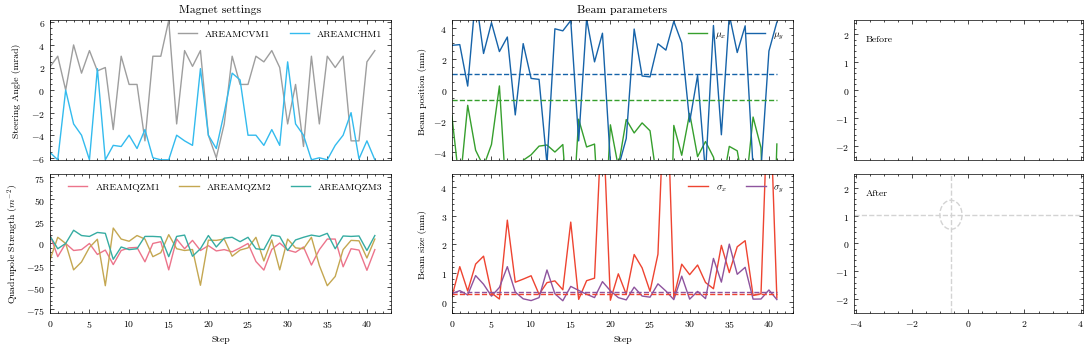

wandb: Network error (ConnectionError), entering retry loop.


In [24]:
_ = episode.plot_summary()

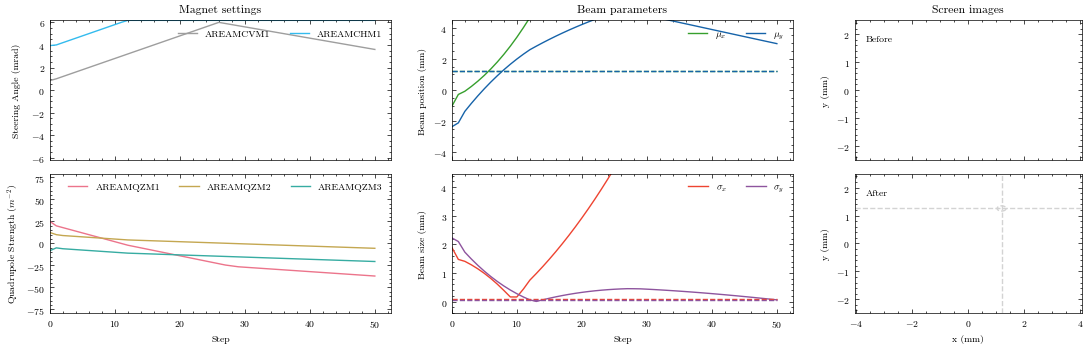

In [23]:
_ = episode.plot_summary()  # GPT 4 Turbo Preview

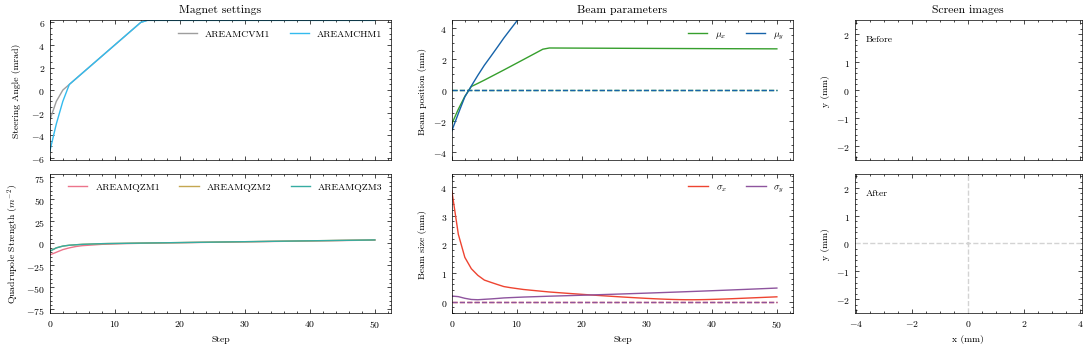

In [23]:
_ = episode.plot_summary()  # GPT 4 Turbo Preview

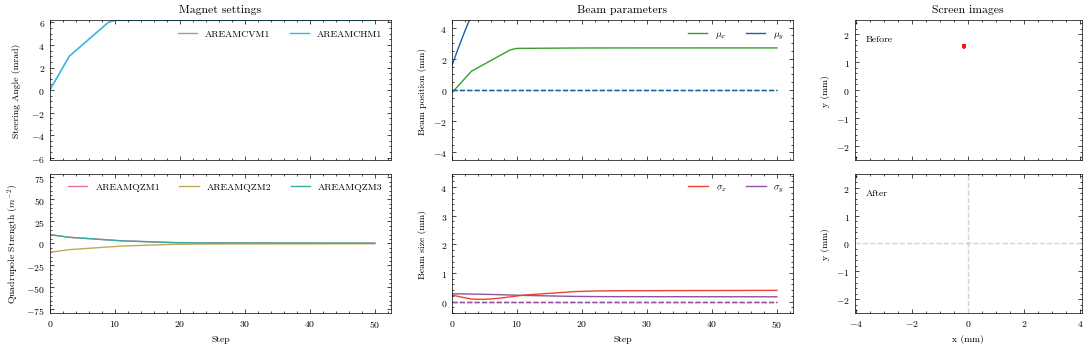

In [23]:
_ = episode.plot_summary()  # GPT-4 (Starting from FDF)

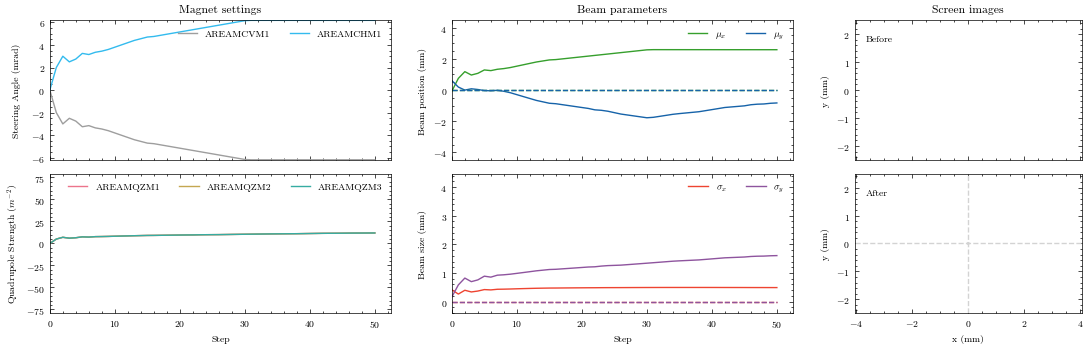

In [23]:
_ = episode.plot_summary()  # GPT-4 (Starting magnets from zero)

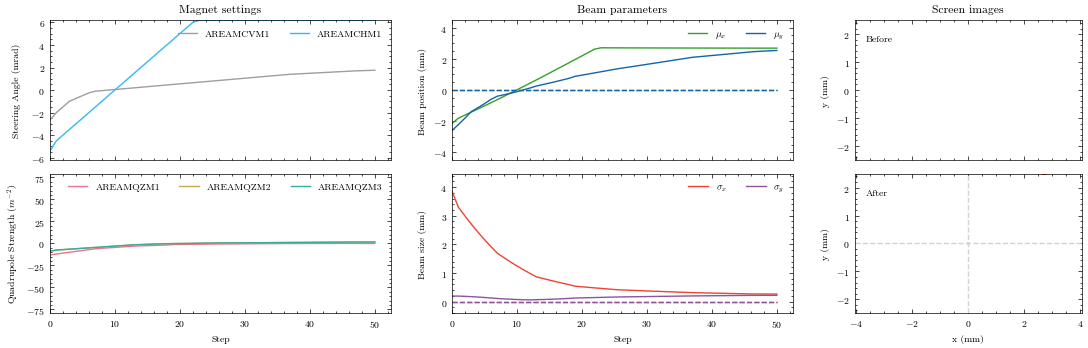

In [23]:
_ = episode.plot_summary()  # GPT-4 (do not set any magnet to zero)

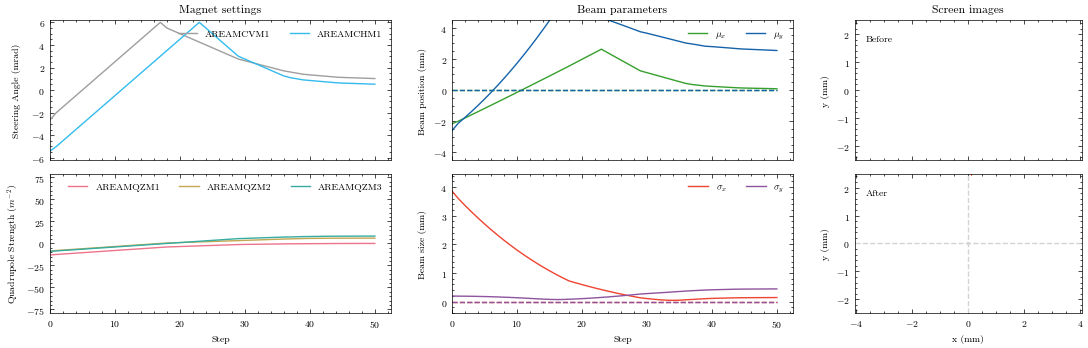

In [23]:
_ = episode.plot_summary()  # GPT-4 (do not set all magnets to zero)

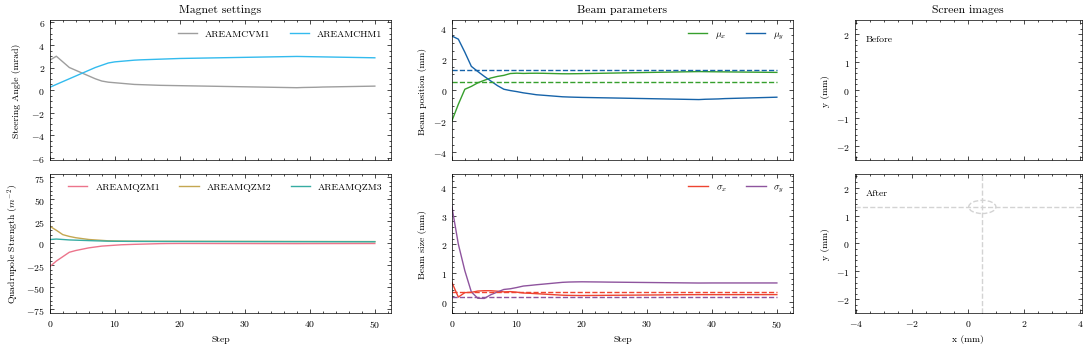

In [23]:
_ = episode.plot_summary()  # GPT-4 (Target beam different index 32)

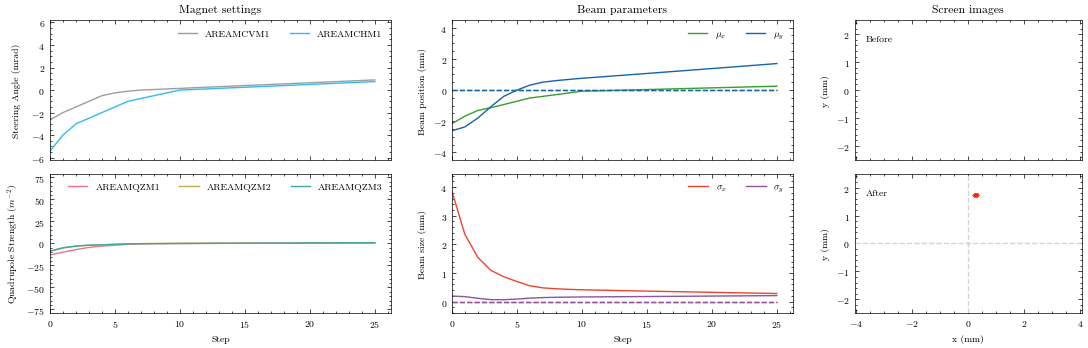

In [23]:
_ = episode.plot_summary()  # GPT-4-Turbo Preview 0125 (target in prompt + smooth)

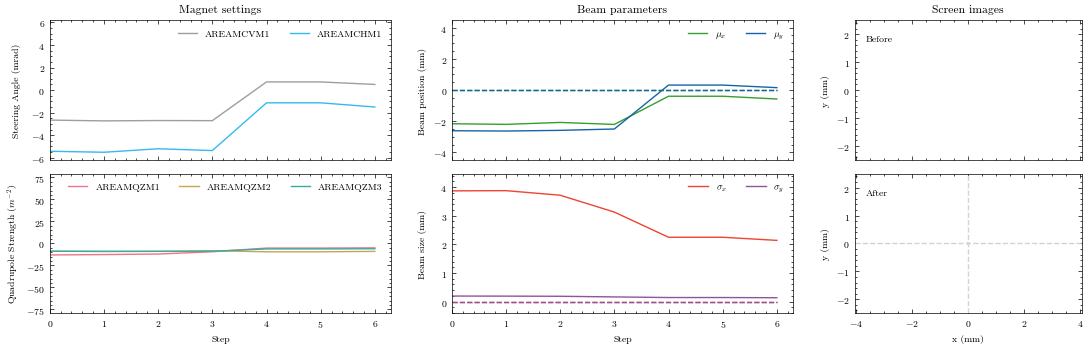

In [23]:
_ = episode.plot_summary()  # Megadolphin 120b

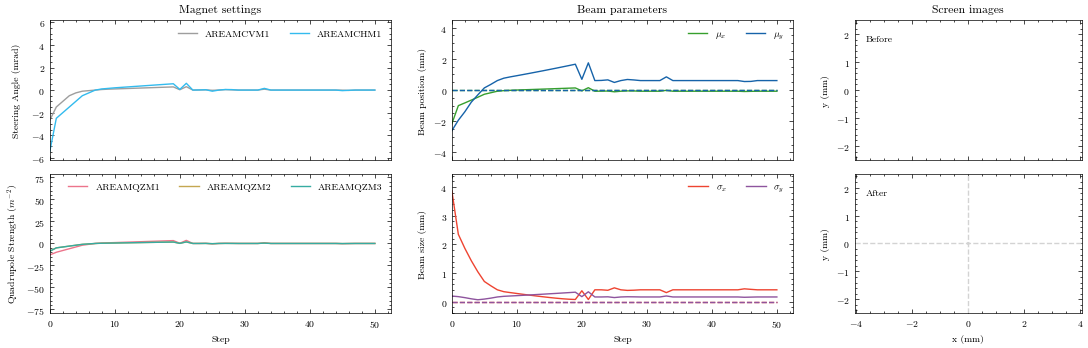

In [23]:
_ = episode.plot_summary()  # GPT-4-Turbo Preview 0125 (no units in history)

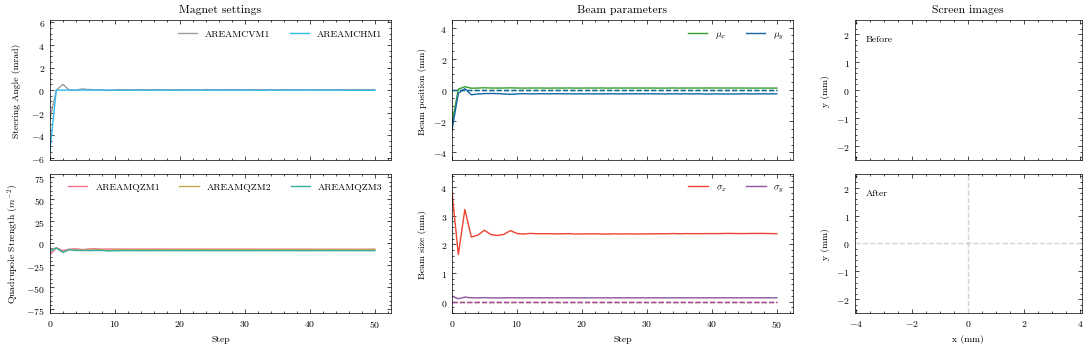

In [23]:
_ = episode.plot_summary()  # Mixtral Instruct (no units in history)

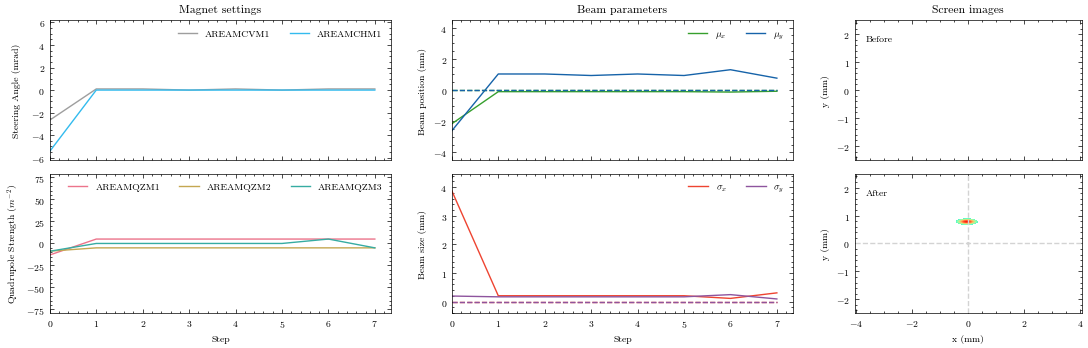

In [28]:
_ = episode.plot_summary()  # Mixtral 7x8b Instruct

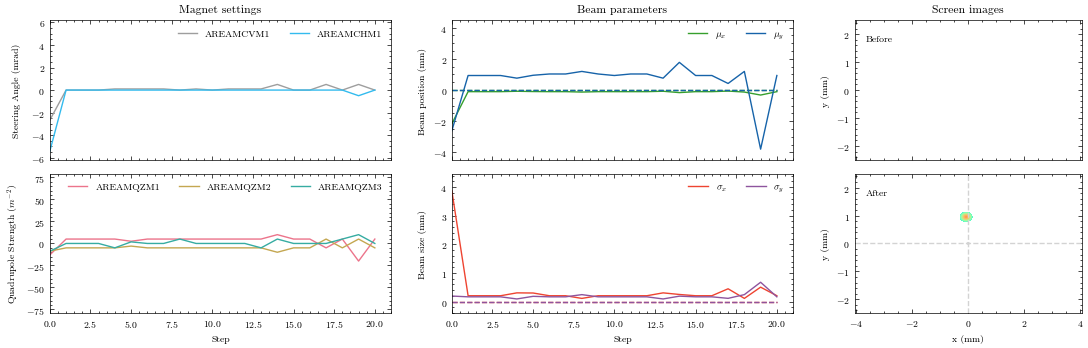

In [29]:
_ = episode.plot_summary()  # Mixtral 7x8b Instruct

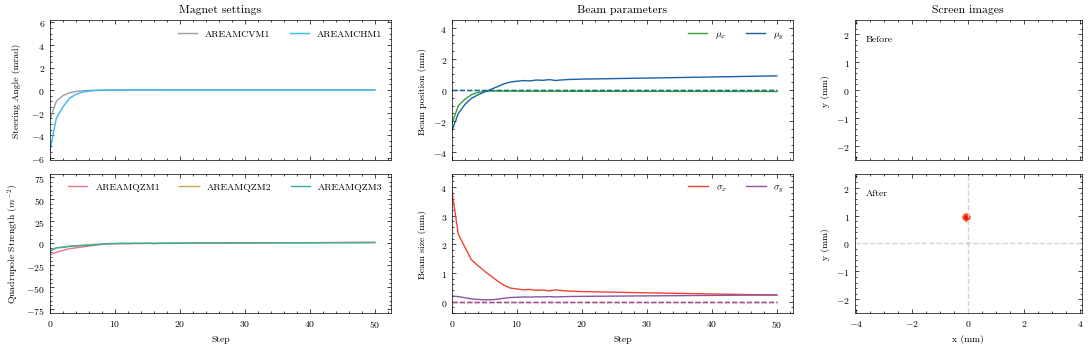

In [26]:
_ = episode.plot_summary()  # gpt-4-0125-preview

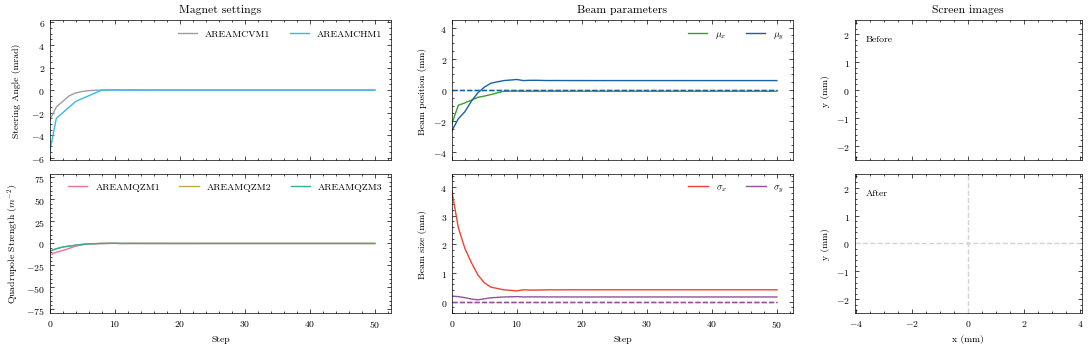

In [26]:
_ = episode.plot_summary()  # gpt-4-0125-preview

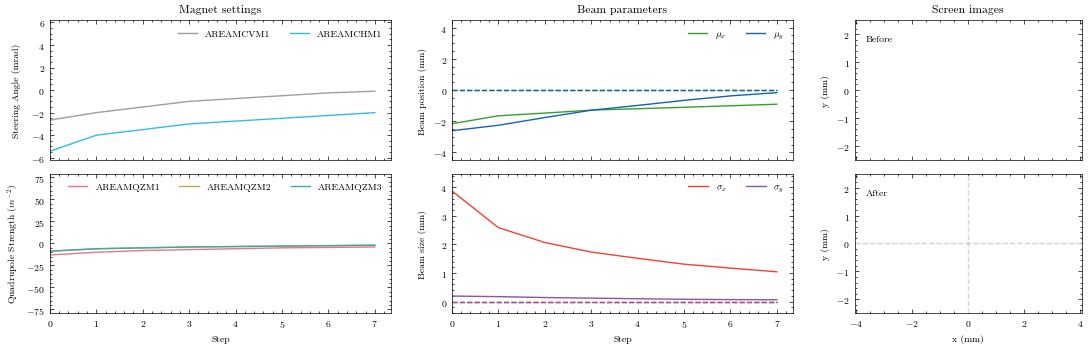

In [26]:
_ = episode.plot_summary()  # GPT-4

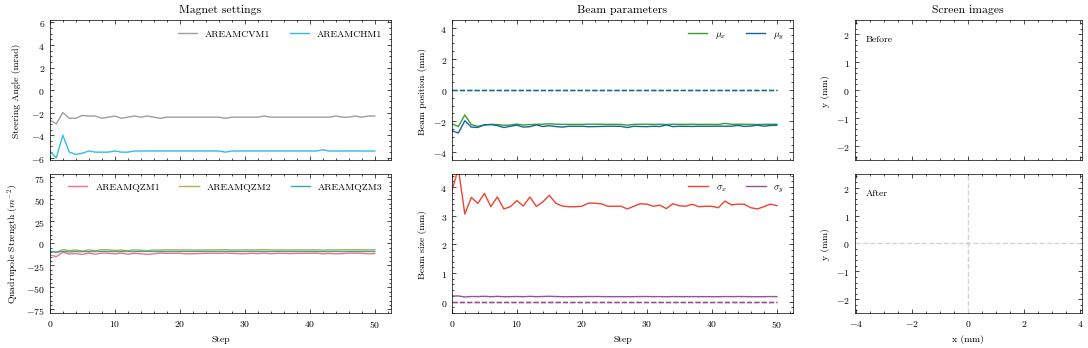

In [26]:
_ = episode.plot_summary()  # GPT-3.5-turbo-1106

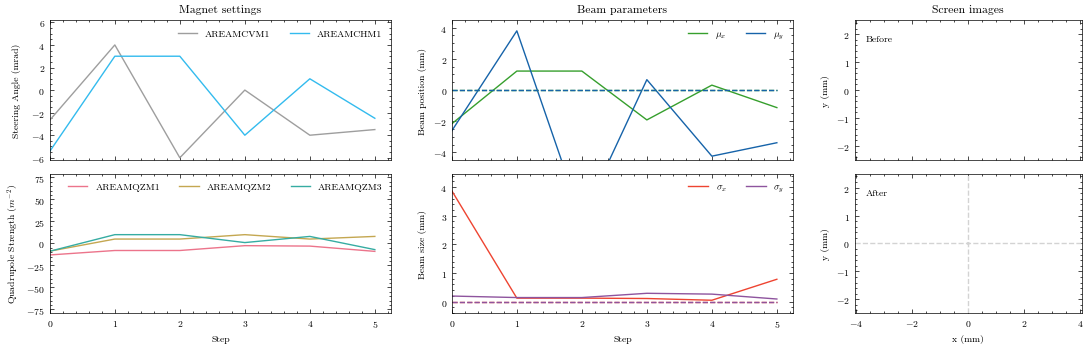

In [26]:
_ = episode.plot_summary()  # mistral-openorca

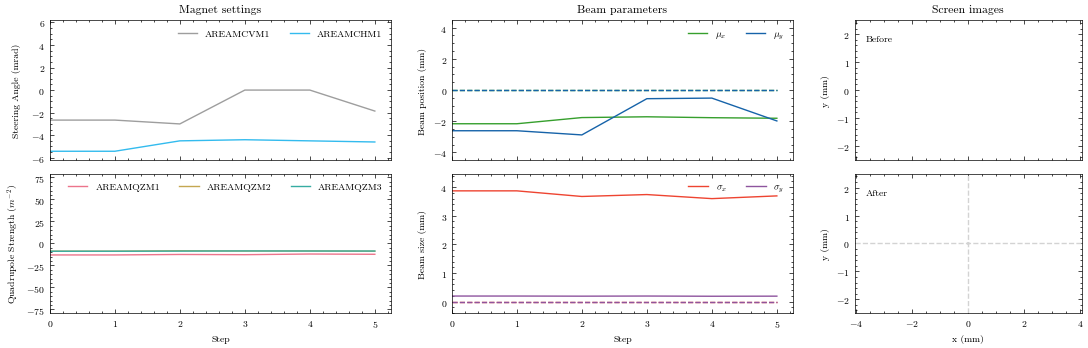

In [26]:
_ = episode.plot_summary()  # Llama2 7B-Chat

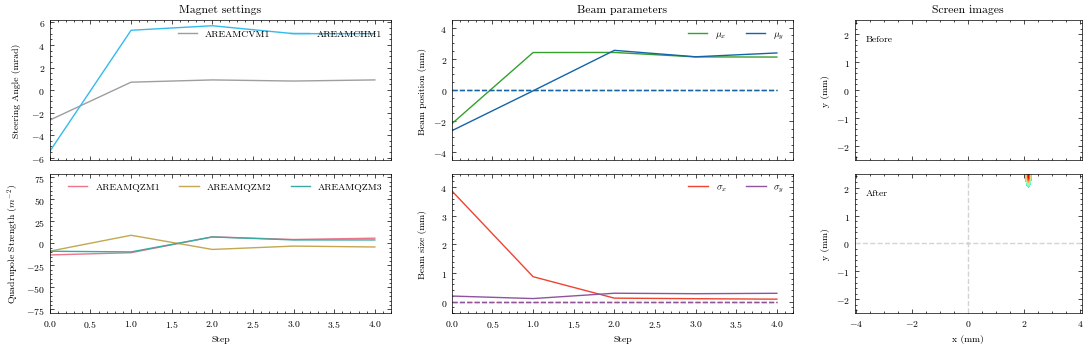

In [26]:
_ = episode.plot_summary()  # Mistral 7B Instruct

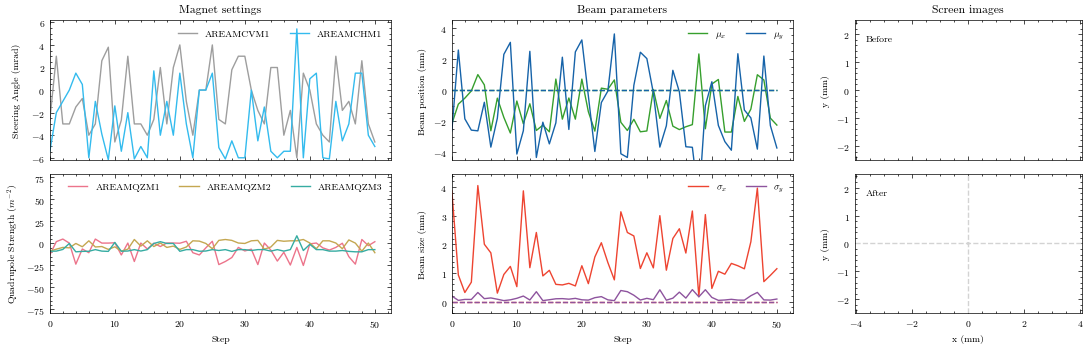

In [26]:
_ = episode.plot_summary()  # Vicuna 7B 16K

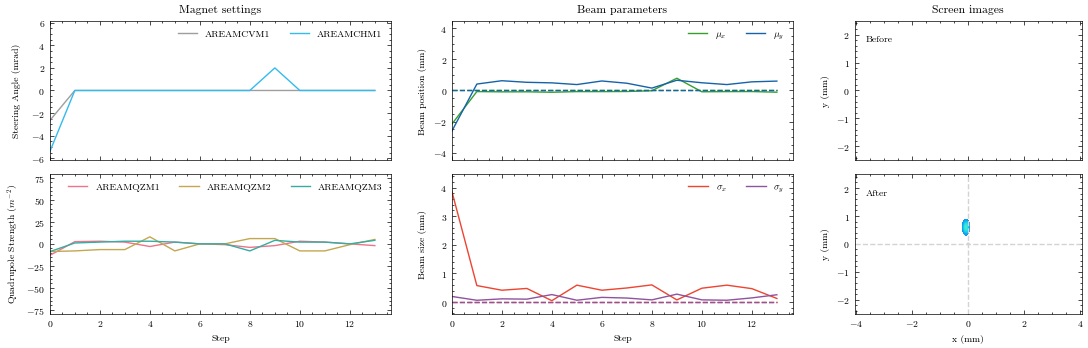

In [24]:
_ = episode.plot_summary()  # Starling

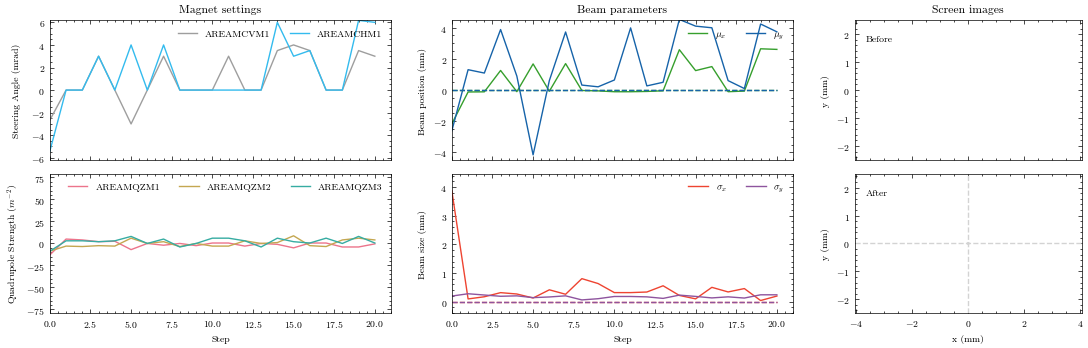

In [24]:
_ = episode.plot_summary()  # Starling

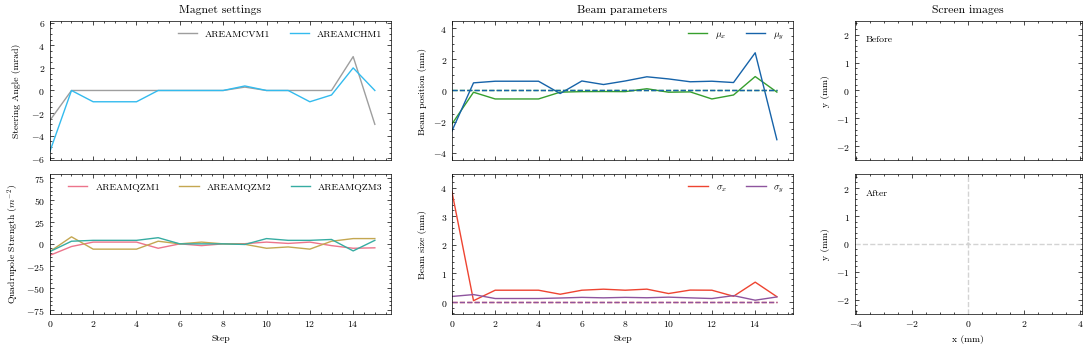

In [27]:
_ = episode.plot_summary()  # Starling

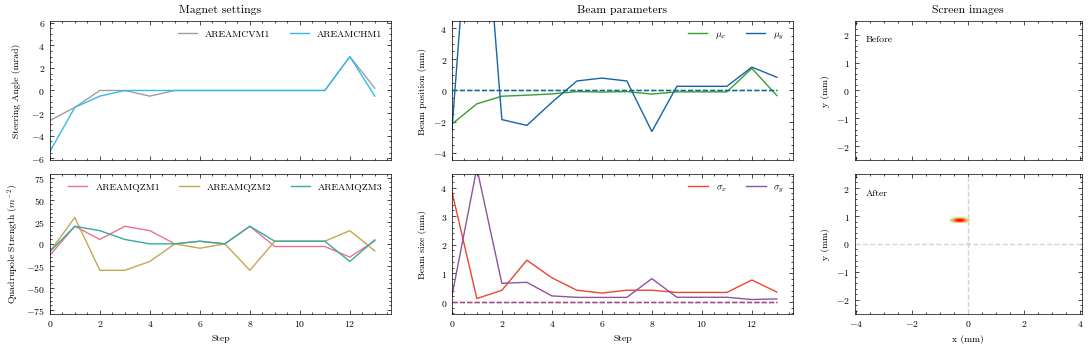

In [24]:
_ = episode.plot_summary()  # Starling

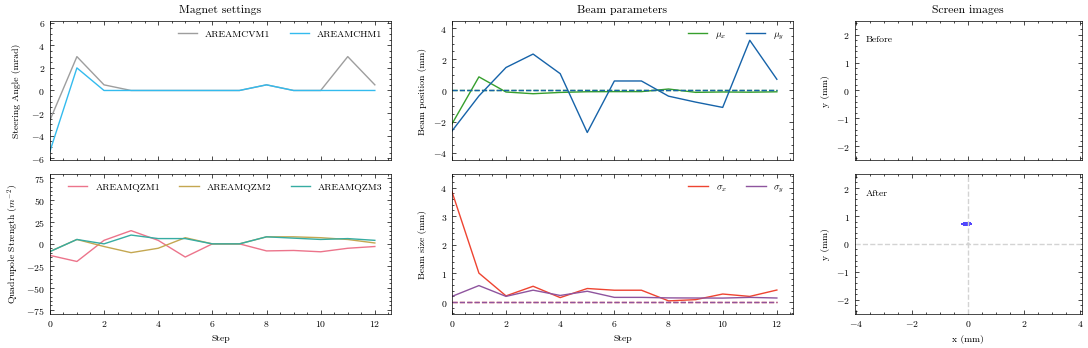

In [24]:
_ = episode.plot_summary()  # Starling

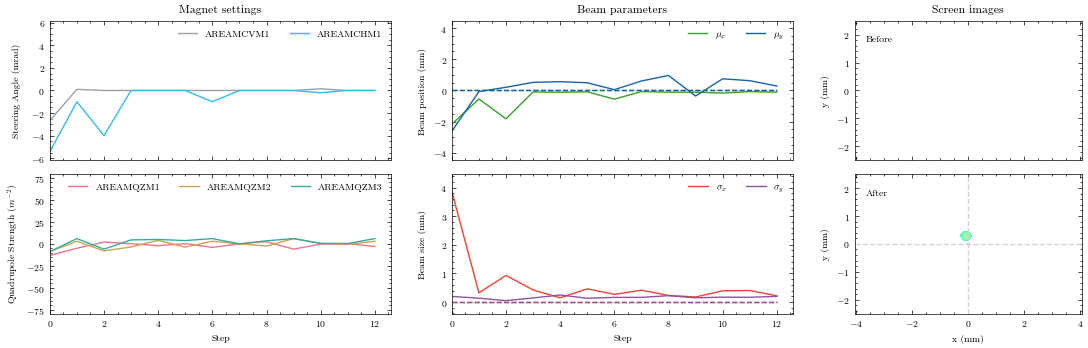

In [24]:
_ = episode.plot_summary()  # Starling

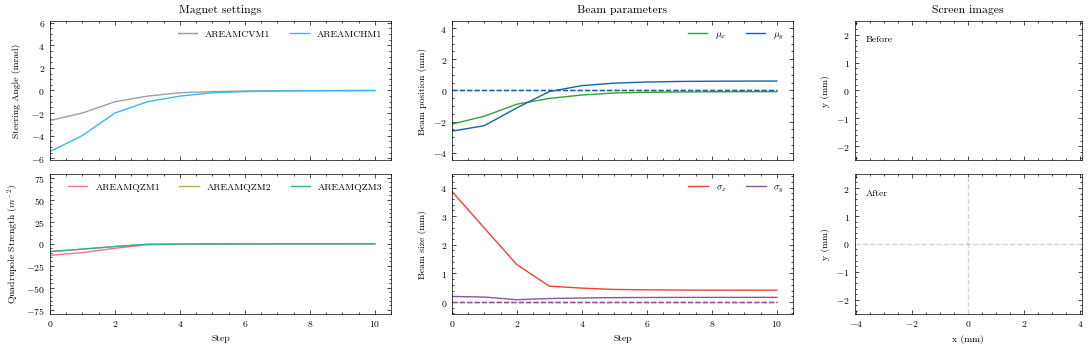

In [24]:
_ = episode.plot_summary()

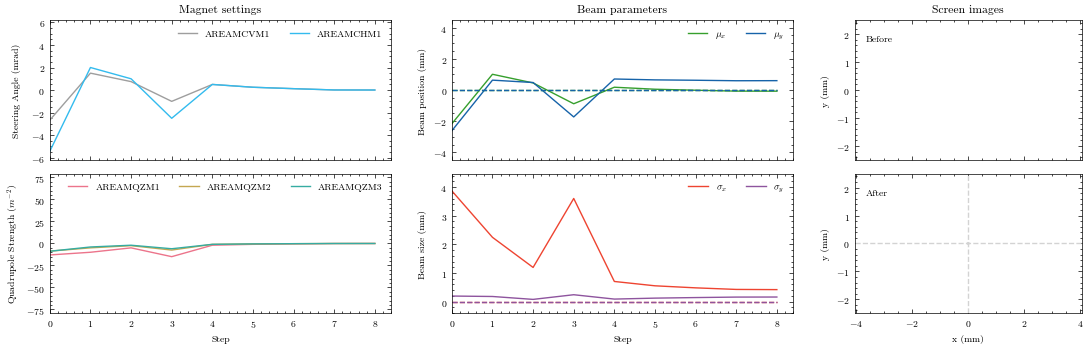

In [23]:
_ = episode.plot_summary()

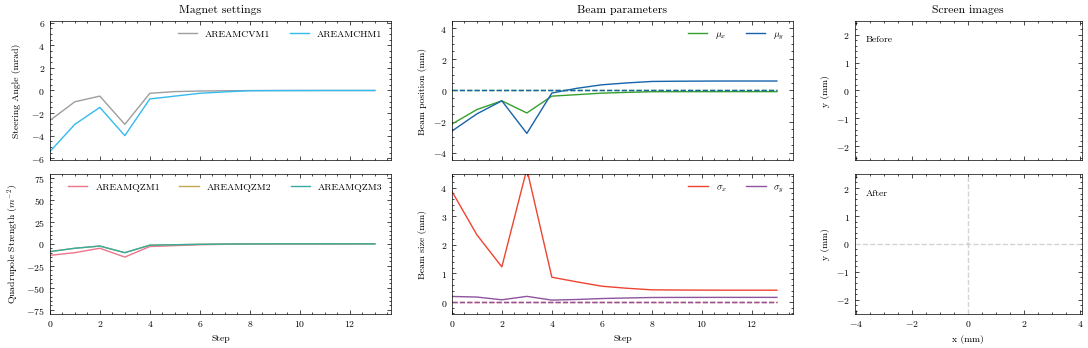

In [23]:
_ = episode.plot_summary()

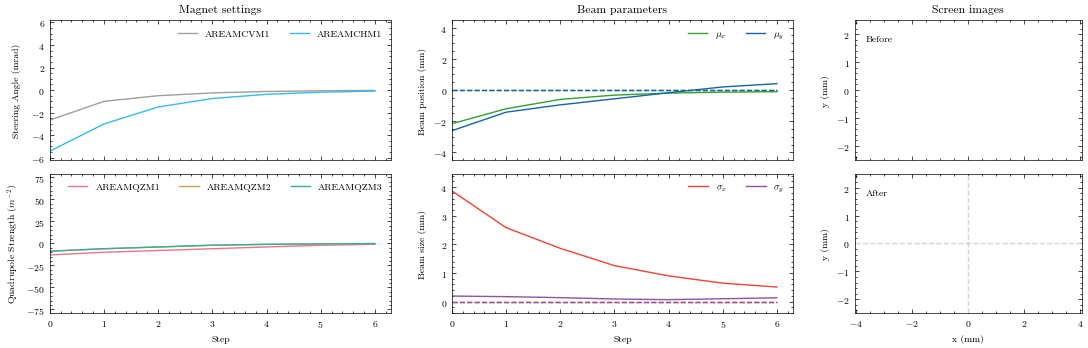

In [23]:
_ = episode.plot_summary()

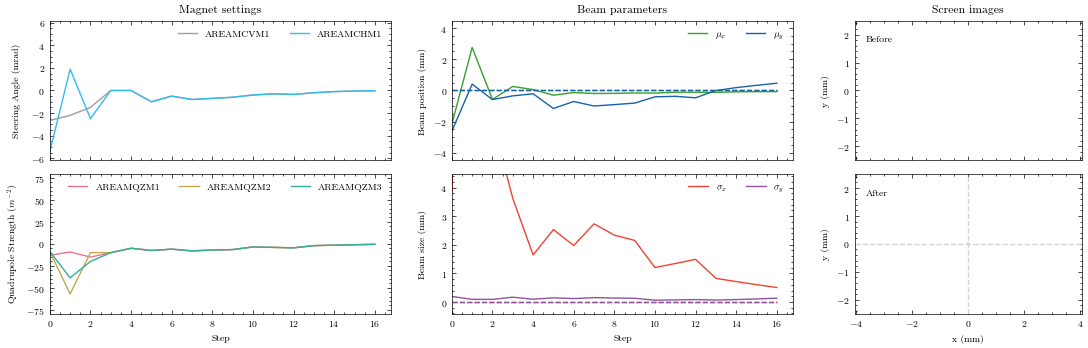

In [23]:
_ = episode.plot_summary()

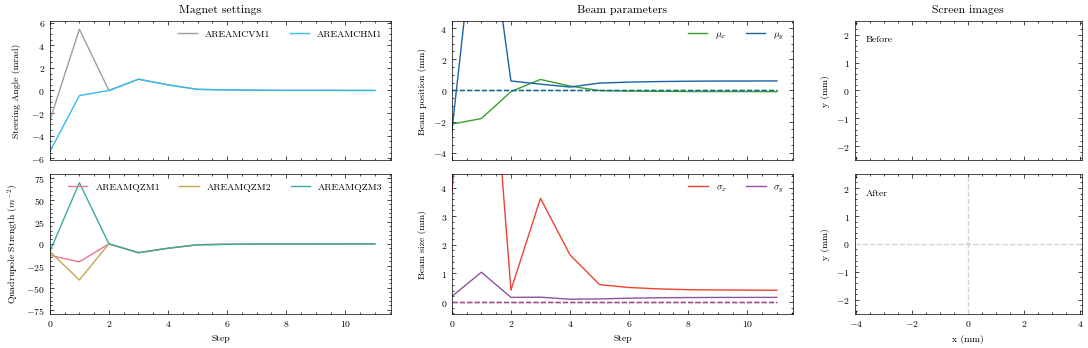

In [28]:
_ = episode.plot_summary()

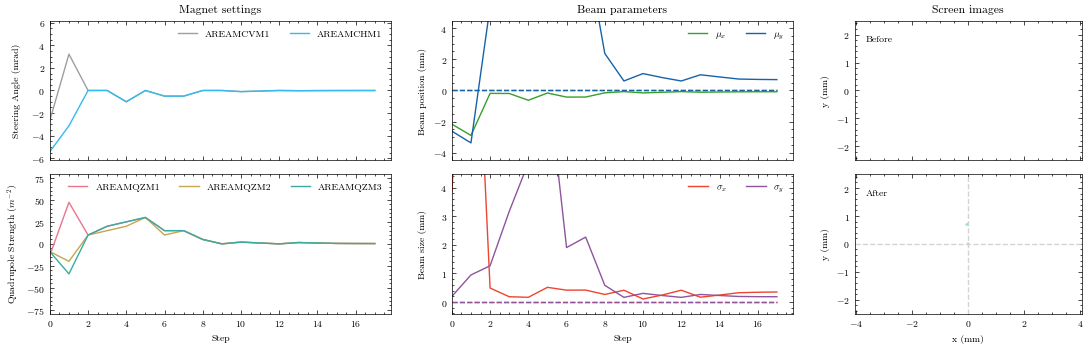

In [23]:
_ = episode.plot_summary()

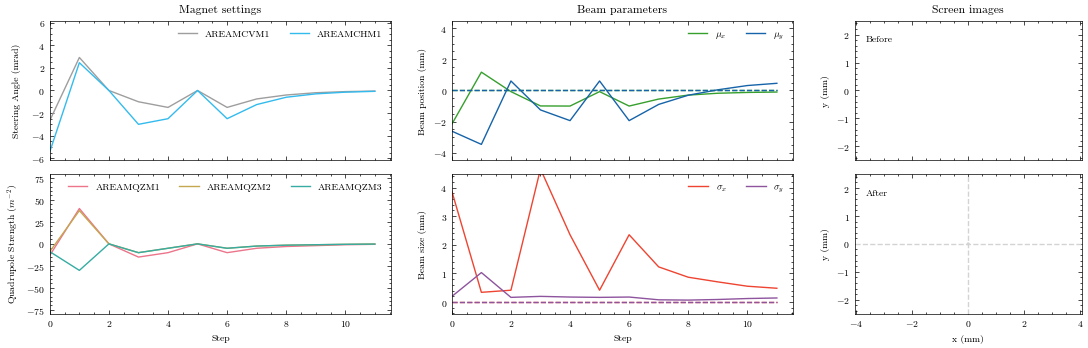

In [23]:
_ = episode.plot_summary()

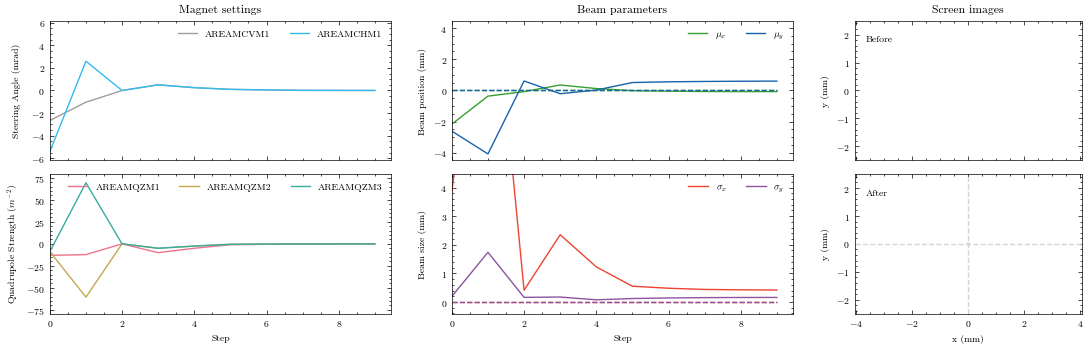

In [23]:
_ = episode.plot_summary()

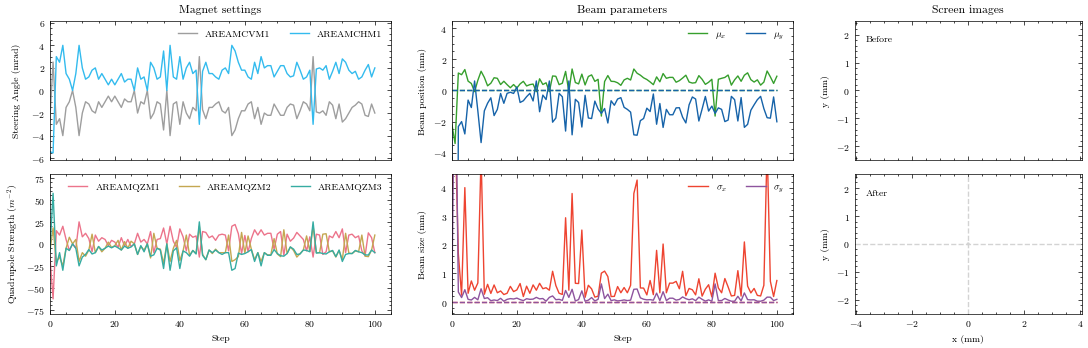

In [23]:
_ = episode.plot_summary()

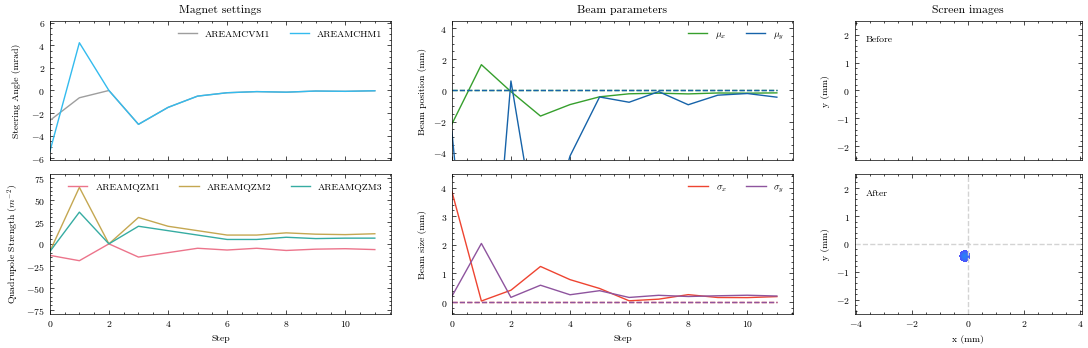

In [67]:
_ = episode.plot_summary()